# Advanced Machine Learning 3rd Project
### Authors: Guilherme Cepeda - 62931, Pedro Serrano - 54853


In this third assignment, we were asked to apply reinforcement learning to the Mountain Cart problem, from Gymnasium. We will split this in two parts, one where we implement Q-Learning, and one where we implement Deep Q-Learning, as requested in the statement.

In [1]:
#imports
import numpy as np
import pandas as pd
from pandas import Series
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.metrics import accuracy_score
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings as w
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import shapiro

import gymnasium as gym
import pickle

### Load Data 

For the **Mountain Car reinforcemet learning problem** the challenge lies in the continuous control problem of getting the car to move uphill by applying appropriate forces. There's no randomness in the transitions between states in the same way as it might be in a discrete grid world like FrozenLake. 

In [2]:
env = gym.make('MountainCar-v0', render_mode="rgb_array") # rendered to an rbg array, returned as a NumPy array containing pixel values
#env = gym.make('MountainCar-v0', render_mode="human") #  will be rendered in a window or on the screen using the standard rendering mechanism (GUI) of the system

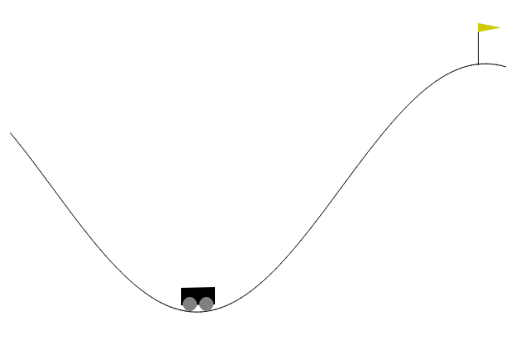

In [3]:
env.reset()
plt.imshow(env.render())
plt.axis('off')
plt.show()

### Exploratory Data Analysis (EDA)

First we started by understanding the possible states and actions of the environment.


Acho que esta parte podia ser so apagada tbh

#### States


In [10]:
env.observation_space #Position of the car along the x-axis, Min: -1.2 Max: 0.6
                      #Velocity of the car, Min:-0.07 Max: 0.07

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [76]:
env.observation_space.high[0]

0.6

#### Actions

3 actions:
* Drive left
* Stay neutral
* Drive right

In [11]:
print(env.action_space) 
print("\n",env.action_space.n)

Discrete(3)

 3


In [75]:
env.action_space.sample() # generates a random action sample between 0(left), 1 (neutral) and 2(right)


0

In [60]:
env.step(env.action_space.sample())# executes an action

(array([-0.5742453 ,  0.00311769], dtype=float32), -1.0, False, False, {})

In [72]:
print(env.unwrapped)

<MountainCarEnv<MountainCar-v0>>


### Q - Learning

The Q-Learning algorithm is an model-free, off-policy method of doing Reinforcement Learning. This means we will not be estimating the transition matrix and the rewards, and will be going straight after an optimal policy.

How do we do this?
We create a Q-table, which is a lookup table os states by actions, where, in each entry [state[i], action[i]] we have stored the optimal policy for that specific request. We estimate each Q value as the sum of the immediate reward, plus the maximum Q value of the possible future actions. We usualy add a weight - the discount factor - to this second part to balance out how much we want to reward the current reward. We expect the optimal discount factor in this problem to be fairly high - its like this is most cases, we believe.

In [4]:
TRAINING = True
EPISODES = 5000

As presented in the statement, the space is continuous, so we will need to turn it into a discrete space. 

We use the numpy linspace function to separete the entire range of the position and velocity scalers in equal parts. Here we initilly picked 5 (yes, it was very small), and tested bigger and bigger numbers until reaching the optimum value.

(não corri nada acima de 20 tbh, mas vou correr)

In [12]:
# Divide position and velocity into segments
position_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 50)    # position between -1.2 and 0.6
velocity_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 50)    # velocity between -0.07 and 0.07

Here is where we initialize some of the models parameters

The Q-table starts off by all zeros - we also tested by starting with random numbers, but it didnt improve (later we realized this was useless, since we were starting our epsilon at 1)

The treshold is an alternitive to having a fixed number of episodes - instead we pick a very low treshold, and if we dont improve more than the threshold, we stop running.

We have talked about the discount factor before, but here we also initizalize the learning rate - still dont know what this is specifically.

We start our epsilon at 1, and keep decreasing with every episode. The epsilon gives our how much of our decision is going to be random, meaning we start off with a completely random decision, and make them less random with every episode by using our Q-table

The rewards per episode is just an array, initialized at all zeros, where we will be updating our rewards.

In [13]:
q_table = np.zeros((len(position_space), len(velocity_space), env.action_space.n)) # initialize the q table with dimension 20x20x3

#set the threshold number for checking the convergence of the value function
threshold = 1e-20

alpha = 0.9 # alpha = learning rate
gamma = 0.9 # gamma = discount factor

epsilon = 1 # 100% random actions
epsilon_decay_rate = 2/EPISODES # epsilon decay rate

random_n_g = np.random.default_rng()   # random number generator

rewards_per_episode = np.zeros(EPISODES) # rewards per episode

In [14]:
def test():

    # Divide position and velocity into segments
    position_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # position between -1.2 and 0.6
    velocity_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # velocity between -0.07 and 0.07

    if(TRAINING):
        #if we are training, we begin with an empty Q-table. Alternitivly, we can initialize random numbers
        q_table = np.zeros((len(position_space), len(velocity_space), env.action_space.n)) # initialize the q table with dimension 20x20x3
    else:
        #Otherwise, we just load the previous Q-table
        f = open('mountain_car.pkl', 'rb')
        q_table = pickle.load(f)
        f.close()

    #set the threshold number for checking the convergence of the value function
    threshold = 1e-10 # 1e-20 no effect on the episodes
                     # 1e-5 the graph becomes mostly straight and fucks the test no longer works so threshold > 1e-5

    alpha = 0.9 # alpha = learning rate
    gamma = 0.9 # gamma = discount factor

    epsilon = 1 # 100% random actions
    epsilon_decay_rate = 2/EPISODES # epsilon decay rate

    random_n_g = np.random.default_rng()   # random number generator

    rewards_per_episode = np.zeros(EPISODES) # rewards per episode

    for i in range(EPISODES):

        state = env.reset()[0]      # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], position_space)
        state_v = np.digitize(state[1], velocity_space)

        terminated = False # when terminated is true it means we reached our goal

        rewards = 0 # each reward is -1

        previous_q_table = np.copy(q_table)  # Copy of the Q-table from the previous episode

        while(not terminated and rewards>-1000):

            if TRAINING and random_n_g.random() < epsilon:
                # Choose random action (0=drive left, 1=stay neutral, 2=drive right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state_p, state_v, :]) # finds the index of the action that has the highest Q-value for the specified state in the Q-values array

            new_state,reward,terminated,_,_ = env.step(action)
            
            new_state_p = np.digitize(new_state[0], position_space)
            new_state_v = np.digitize(new_state[1], velocity_space)

            if TRAINING:
                q_table[state_p, state_v, action] = q_table[state_p, state_v, action] + alpha * (
                    reward + gamma *np.max(q_table[new_state_p, new_state_v,:]) - q_table[state_p, state_v, action]
                )

            state = new_state
            state_p = new_state_p
            state_v = new_state_v

            rewards+=reward

        epsilon = max(epsilon - epsilon_decay_rate, 0)

        rewards_per_episode[i] = rewards

        # Check for convergence based on the change in Q-values
        if TRAINING and i > 0:
            q_change = np.mean(np.abs(q_table - previous_q_table))
            if q_change < threshold:
                print(f"Convergence reached. Stopping at episode {i}.")
                break
            previous_q_table = np.copy(q_table)

    env.close()

    # Save Q table to file
    if TRAINING:
        f = open('mountain_car.pkl','wb')
        pickle.dump(q_table, f)
        f.close()


    #Plot the results
    mean_rewards = np.zeros(EPISODES)
    for t in range(EPISODES):
        mean_rewards[t] = np.mean(rewards_per_episode[max(0, t-100):(t+1)]) #  technique to smooth out fluctuations in the learning curve to provide a more stable measure of the agent's performance over time.
    plt.plot(mean_rewards)
    plt.savefig(f'mountain_car.png')


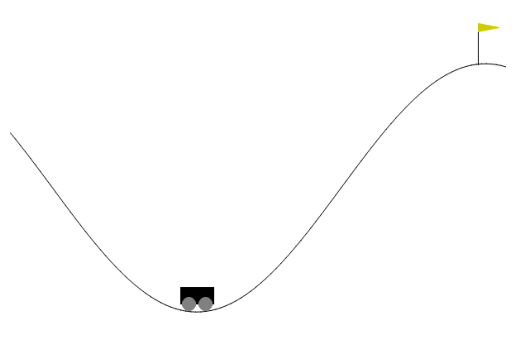

In [9]:
plt.imshow(env.render())
plt.axis('off')
plt.show()

Below, we show a plot, displaying how the rewards improve with the episodes.

We can see its learning, and then stops at a little over -200. Why is the number negative? We dont assign a reward to finishing, and we decrease our reward for every step - this is to make the algorithm choose faster paths, meaning our car took a little less than 200 steps to get to the top.

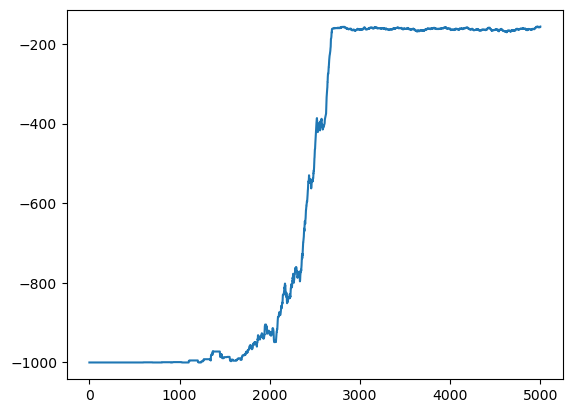

In [16]:
#training
test()

Before, we were just trainin the model. Now, lets test how good our Q-table really is. 

Here, we use the gym package to render the GUI, and do the same plot we did before, but this time, since the values are close together, we can cleary see we get a maximum of -145, meaning we can get our car to the top with 145 steps.

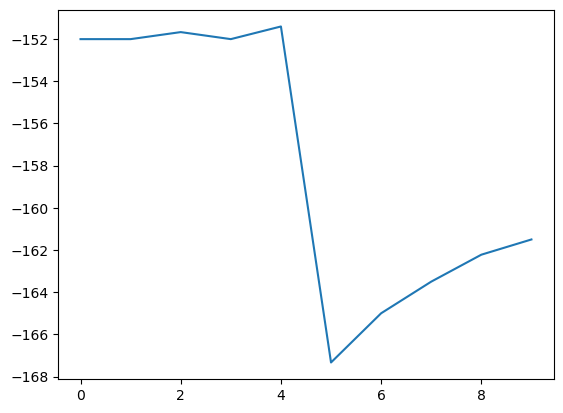

In [17]:
TRAINING = False
EPISODES = 10
env = gym.make('MountainCar-v0', render_mode="human") 
#test
test()

 * CHECK IF EPOCHS ARE NEEDED 
 * test cycle with threshold for restraining the number of episodes

## Time Series Forecasting

The following process can be summarized as follows:
1. Present 5th worm from the data.
2. Test harness.
3. Persistence model.
4. Data Analysis.
5. ARIMA Models.
6. Model Evaluation.


The problem here is to predict, for a specific worm, how can we model its motion, i.e., the eigenworm
Perform time series analysis to model the movement of one single worm. In this case, we will consider the worm in the train set indexed by 5.

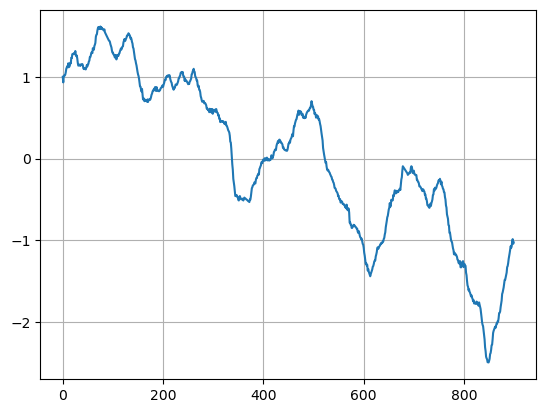

In [10]:
worm = X_train.iloc[5]

plt.plot(range(0,900), X_train.iloc[5])
plt.grid()
plt.show()

### 2 - Test harness

We must develop a test harness to investigate the data and evaluate candidate models. This involves two steps:
- Defining a validation dataset
- Developing a method for model evaluation

#### Validation dataset

From the 900 observations, the final 100 will be used to validate the final model (the so-called independent validation set). Thus, we will create two datasets:
* `dataset`: first 800 observations 
* `validation`: Last 100 observations

The validation set is ~ 11 % of the original dataset.

In [11]:
# split data to have an independent validation set
split_point = len(worm) - 100
dataset, validation = worm[0:split_point], worm[split_point:]

print(dataset.shape) 
print(validation.shape) 

(800,)
(100,)


#### Model evaluation

Model evaluation will only be performed on the data in `dataset` prepared previously. Model evaluation involves two elements:
1. Performance measure
2. Test strategy

**Performance measure**

The observations are a count of the movement of one single worm. We will evaluate the performance of predictions using the root mean squared error (RMSE). This will give more weight to predictions that are grossly wrong and will have the same units as the original data. Any transforms to the data must be reversed before the RMSE is calculated and reported to make the performance between different methods directly comparable.

We can use the function `mean_squared_error()`from scikit-learn to calculate the mean squared error between a list of expected values (the test set) and the list of predictions.

**Test strategy**

Candidate models will be evaluated using walk-forward validation. This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data. The walk-forward validation will work as follows:
1. The first 50% of the datset will be held back to train the model.
2. The remaining 50% of the dataset will be iterated and test the model.
3. For each step in the test dataset:
  * A model will be trained
  * A one-step prediction made and the prediction stored for later evaluation
  * The actual observation from the test dataset will be added to the training dataset for the next iteration
4. The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

### 3 - Persistence model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared. The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step. We can plug this directly into the test harness defined previously.

We present the RMSE value, but to have a better unnderstanding of this value we calculate a percentage of the RMSE with the whole worm dataset.

In [12]:
# prepare data
X = dataset.values
X = X.astype('float32')
train_size = int(len(X) * 0.50) # split dataset 50% for training and 50% for testing
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
  # predict
  yhat = history[-1] # this method only uses the last observation as prediction
  predictions.append(yhat)
  
  # observation
  obs = test[i]
  history.append(obs)

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
  

RMSE: 0.029


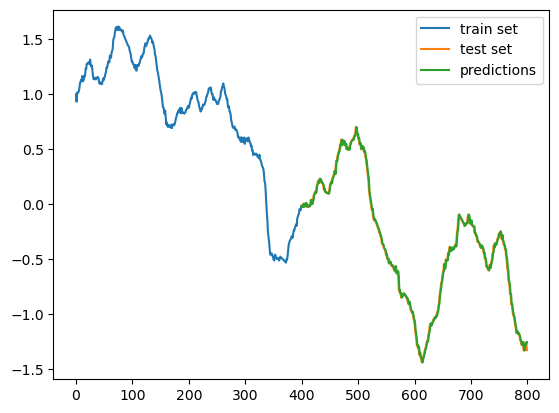

In [13]:
t = np.array([x for x in test])
t = t.flatten()

# plot predictions and expected results
pyplot.plot(train)
#pyplot.plot([None for i in train] + t)
pyplot.plot([None for i in train] + [x for x in t])
pyplot.plot([None for i in train] + [x for x in predictions])
pyplot.legend(['train set','test set','predictions'])
pyplot.show()

### 4 - Data analysis

We can use summary statistics and plots of the data to quickly learn more about the structure of the prediction problem. Here, we will look at the data from four perspectives:
- Summary statistics
- Line plot
- Seasonal line plots
- Density plots

#### Summary statistics

The first thing to do is to verify if the data has missing observations. Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [14]:
dataset.describe()

count    800.000000
mean       0.221784
std        0.813635
min       -1.440910
25%       -0.430526
50%        0.224946
75%        0.935572
max        1.615823
Name: 5, dtype: float64

Some observations:
* The number of observations (count) matches our expectation, meaning we are handling the data correctly.
* The mean is about 0,221, which we might consider our level in this series.
* The standard deviation (average spread from the mean) is relatively large at 0,81, so it suggests that we have a large spread of the data.

#### Line plot

A line plot of a time series can provide a lot of insight into the problem.

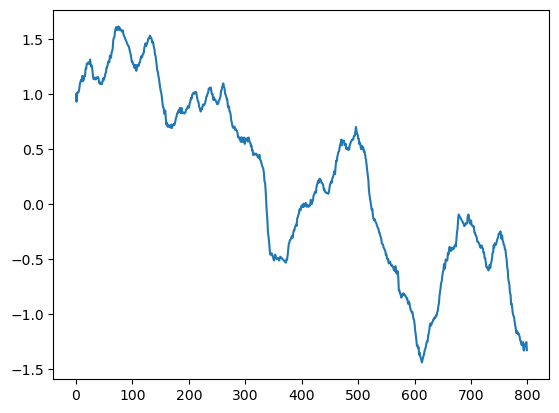

In [15]:
pyplot.plot([x for x in dataset])

Note any obvious temporal structures in the series. Some observations from the plot include:
* There is an decreasing trend of y over time.
* There do not appear to be any obvious outliers.
* There appears to be systematic seasonality to the movement of the  worm for each 210.
* The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).
* The seasonality suggests that the series is almost certainly non-stationary.

#### Seasionality plots

We can confirm the assumption that the seasonality is a 210 (but growing) cycle by eyeballing line plots of the dataset by 210. Creating one line plot for each 210, we can see a similar pattern, although at different levels.

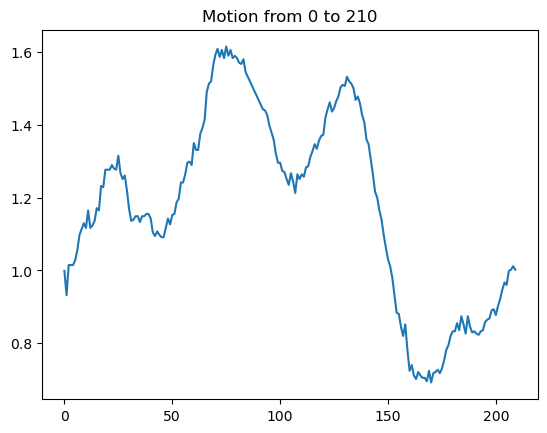

<Figure size 200x100 with 0 Axes>

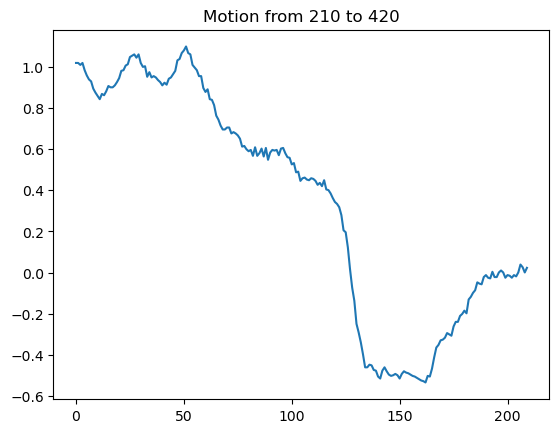

<Figure size 200x100 with 0 Axes>

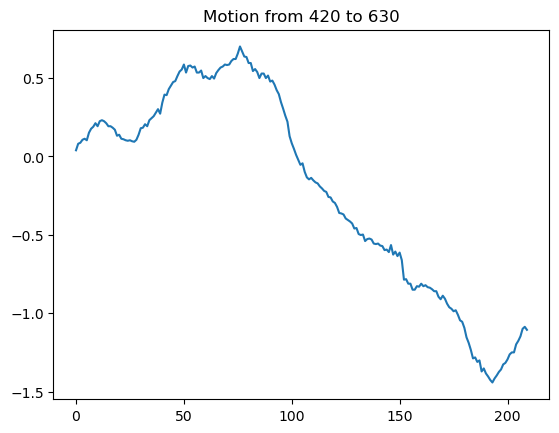

<Figure size 200x100 with 0 Axes>

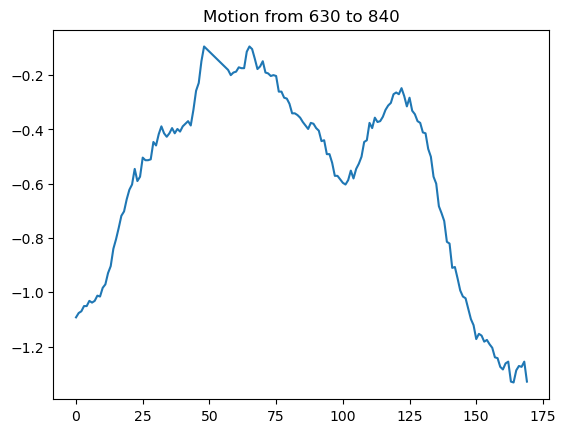

<Figure size 200x100 with 0 Axes>

In [16]:
# Create line plots for each 210
seasonal_plots = 210
for i in range(0, dataset.shape[0], seasonal_plots): #with just one row, shape[0] is not row but column number
    
    plt.title (f"Motion from {i} to {i+seasonal_plots}")
    seasonal = dataset[i:i+seasonal_plots] # just one line 
    pyplot.plot([x for x in seasonal])
    plt.figure(figsize=(2, 1))
    plt.show()

#### Density plots

Reviewing plots of the density of observations can provide further insight into the structure of the data. 
We can see that the distribution is not Gaussian and the shape has two highs (motion y= -0,5 and y = 1).

Axes(0.125,0.11;0.775x0.77)


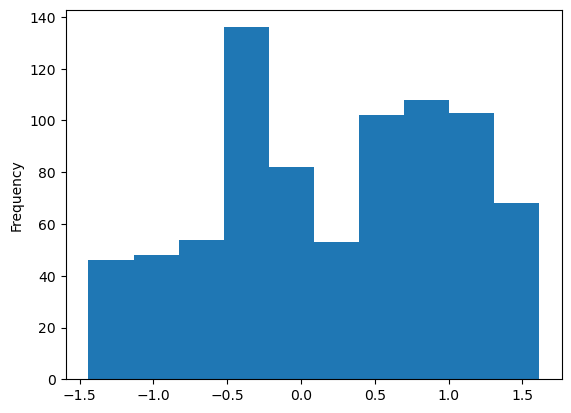

In [17]:
print (dataset.plot(kind='hist'))

Axes(0.125,0.11;0.775x0.77)


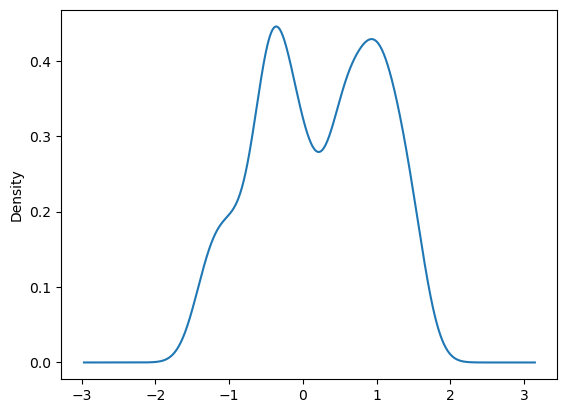

In [18]:
print (dataset.plot(kind='kde'))

### 5 - ARIMA models

Now, we will develop Autoregressive Integrated Moving Average, or ARIMA, models for the problem. We will approach modeling by both manual and automatic configuration of the ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model. As such, we have 3 steps:
- Manually configure the ARIMA
- Automatically configure the ARIMA
- Review residual errors

#### Manually configured ARIMA

The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually. Analysis of the time series data assumes that we are working with a stationary time series. This time series has a trend so is almost certainly non-stationary. We can make it stationary this by first differencing the series and using a statistical test to confirm that the result is stationary.

The simplest method to detrend a time series is calculating the diference between the original observation and the observation at the previous time step.

t211    0.019185
t212    0.086330
t213   -0.006395
t214    0.003198
t215   -0.031974
          ...   
t796   -0.441244
t797   -0.412467
t798   -0.415665
t799   -0.361309
t800   -0.418862
Name: 5, Length: 590, dtype: float64
ADF Statistic: -3.3119693057116626
p-value: 0.014351850577817021
usedlag: 5
nobs: 584
critical values: {'1%': -3.4415970480373046, '5%': -2.866501759246704, '10%': -2.5694124827594296}
The time series is stationary.


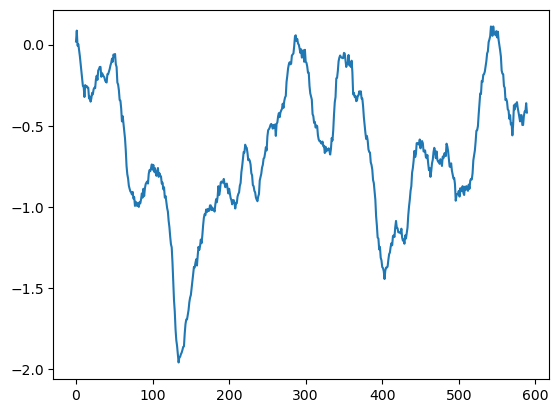

In [19]:
seasonal_plots = 210
    
# Seasonally difference the series with a seasonal interval of seasonal_plots observations
data_diff = dataset.diff(seasonal_plots)
data_diff = data_diff.dropna()  # Remove NaN values created by differencing

# Show the result
print(data_diff)


pyplot.plot([x for x in data_diff])

# Check stationarity using the Dickey-Fuller test
result = adfuller(data_diff, autolag='AIC')

# Print the test statistic, p-value, usedlag(nº of lags used)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("usedlag:", result[2])
print("nobs:", result[3])
print("critical values:", result[4])

# Check if the series is stationary based on the p-value
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

The results show that the test statistic value -3.311 is smaller than the critical value at 5% of -2.866, almost reaching the 1% critical value. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke). Rejecting the null hypothesis means that the process has no unit root, and, in turn, that the time series is stationary or does not have time-dependent structure.

The plot does not show any obvious seasonality or trend, suggesting the seasonally differenced dataset is a good starting point for modeling.

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. Note, we are going to use the stationary data as our dataset.

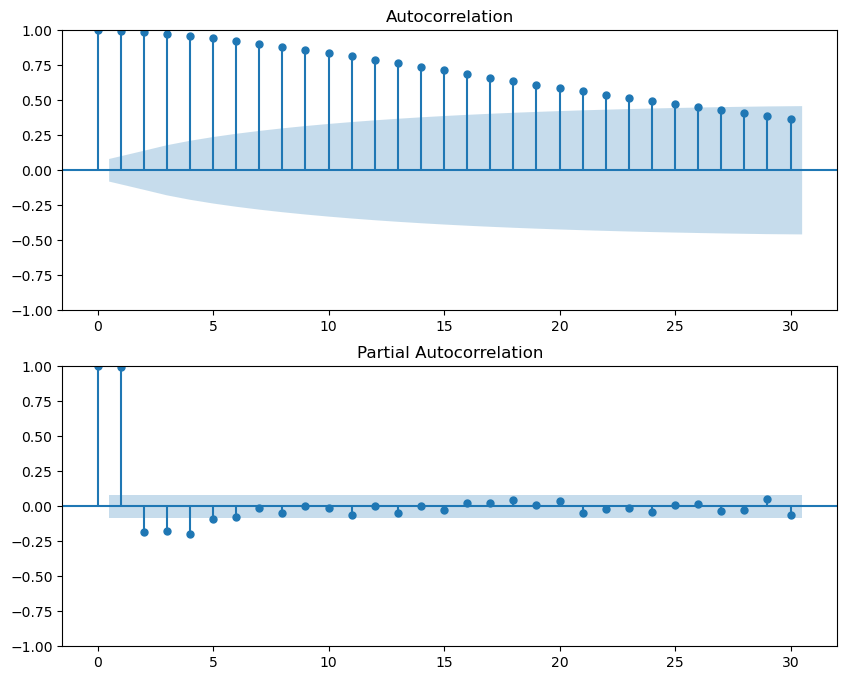

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data_diff, lags=30, ax=ax[0])
plot_pacf(data_diff, lags=30, ax=ax[1]) 
plt.show()

We select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.

In general, the ACF plot is used to identify the order of the Moving Average (MA) term, while the PACF plot is used to identify the order of the Autoregressive (AR) term.

If the ACF plot showed a sharp cutoff after lag k and the PACF plot shows a sharp drop after lag k, then we could use an MA(k) model. 

If both the ACF and PACF plots showed a gradual decay, then we could use an ARMA model.

The ACF plot shows a sharp drop after lag k and the PACF plot shows a sharp cutoff after lag k, then we can use an AR(k) model, so for this case is k = 1 (AR(1)).

So we chose the p = 1, d = 0 because its a stationary data and q = 1 to train the ARIMA model.


In [21]:
# data_diff #stationery dataset

# train an ARIMA model following the walk-forward validation

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):

    X = X.astype('float32')
    train_size = int(len(X) * 0.50) # split dataset 50% for training and 50% for testing
    train, test = X[0:train_size], X[train_size:]

    # walk-forward validation
    history = [x for x in train]
    predictions = []
    for i in range(len(test)):
      # predict
      model = ARIMA(history, order=arima_order) 
      model_fit = model.fit() #disp=0
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      # observation
      obs = test[i]
      history.append(obs)

      #ignore warnings
      w.filterwarnings('ignore')

    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse, test, predictions
    # print('RMSE: %.3f' % rmse)


print (f"data_diff.shape {data_diff.shape}")
# prepare data
X = data_diff.values #stationery dataset

rmse = evaluate_arima_model(X, (1, 0, 1)) #by observation of ACF, PACF plots for p, d, q ~ 1, 0, 1
print('RMSE: {:.3f}'.format(rmse[0])) # RMSE Tuple, first result (returns the 3 variables in one)


data_diff.shape (590,)
RMSE: 0.041


#### Automatically configure the ARIMA (Grid search ARIMA hyperparameters)

The ACF and PACF plots suggest that an ARIMA(1,0,1) or similar may be the best that we can do. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and check that no models result in better out of sample RMSE performance. We will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance on the test set. We will use a grid search to explore all combinations in a subset of integer values.

 ARIMA model is trained over the stationary data (d = 0).

In [22]:
# evaluate combinations of p, d and q values for an ARIMA mode, then return best_cfg and best_score
def evaluate_models_gsearch (dataset, p_values, d_value, q_values):
    
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None #positive infinity and None for being updated
    for p in p_values:
        for d in d_value:
            for q in q_values:
                order = (p,d,q)
                try: #treat exceptions from ARIMA
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse[0] < best_score:
                        best_score, best_cfg = rmse[0], order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse[0]))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score


# define the parameter values that should be searched
p_values = range(0, 7)
d_value = [0]
q_values = range(0, 7)

w.filterwarnings("ignore") # ignore warnings

#stationary dataset
print (f"data_diff.shape {data_diff.shape}")

best_cfg, best_score = evaluate_models_gsearch (data_diff.values, p_values, d_value, q_values)
print('END Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

data_diff.shape (590,)
ARIMA(0, 0, 0) RMSE=0.391
ARIMA(0, 0, 1) RMSE=0.207
ARIMA(0, 0, 2) RMSE=0.140
ARIMA(0, 0, 3) RMSE=0.096
ARIMA(0, 0, 4) RMSE=0.083
ARIMA(0, 0, 5) RMSE=0.068
ARIMA(0, 0, 6) RMSE=0.064
ARIMA(1, 0, 0) RMSE=0.041
ARIMA(1, 0, 1) RMSE=0.041
ARIMA(1, 0, 2) RMSE=0.039
ARIMA(1, 0, 3) RMSE=0.039
ARIMA(1, 0, 4) RMSE=0.038
ARIMA(1, 0, 5) RMSE=0.037
ARIMA(1, 0, 6) RMSE=0.037
ARIMA(2, 0, 0) RMSE=0.041
ARIMA(2, 0, 1) RMSE=0.041
ARIMA(2, 0, 2) RMSE=0.036
ARIMA(2, 0, 3) RMSE=0.036
ARIMA(2, 0, 4) RMSE=0.036
ARIMA(2, 0, 5) RMSE=0.036
ARIMA(2, 0, 6) RMSE=0.037
ARIMA(3, 0, 0) RMSE=0.038
ARIMA(3, 0, 1) RMSE=0.037
ARIMA(3, 0, 2) RMSE=0.036
ARIMA(3, 0, 3) RMSE=0.037
ARIMA(3, 0, 4) RMSE=0.037
ARIMA(3, 0, 5) RMSE=0.036
ARIMA(3, 0, 6) RMSE=0.036
ARIMA(4, 0, 0) RMSE=0.037
ARIMA(4, 0, 1) RMSE=0.037
ARIMA(4, 0, 2) RMSE=0.036
ARIMA(4, 0, 3) RMSE=0.037
ARIMA(4, 0, 4) RMSE=0.036
ARIMA(4, 0, 5) RMSE=0.038
ARIMA(4, 0, 6) RMSE=0.037
ARIMA(5, 0, 0) RMSE=0.037
ARIMA(5, 0, 1) RMSE=0.037
ARIMA(5, 0, 2) 

#### Review residual errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean. We can check this by using summary statistics and plots to investigate the residual errors from the best model.

We will retrain the model with the best parameters found by the grid search ARIMA and obtain the summary statistics and the density plots.

In [23]:
print (f"best_cfg: {best_cfg}")
print (f"best_score: {best_score}")

#apply best_cfg
rmse,ds_test, ds_pred = evaluate_arima_model(data_diff.values, best_cfg) # (4, 0, 4) best params

ds_test = pd.DataFrame(ds_test)
ds_pred = pd.DataFrame(ds_pred)

print(f"ds_test.shape {ds_test.shape} ds_test.head() {ds_test.head()}")
print(f"ds_pred.shape {ds_pred.shape} ds_pred.head() {ds_pred.head()}")

# To obtain the residuals you need to subtract the true values and the predictions
residuals = ds_test - ds_pred

# Show the result
print(f"residuals.shape {residuals.shape} residuals.head() {residuals.head()}")

# Test for normality using the Shapiro-Wilk test
stat, p = shapiro(residuals)

# Print the test statistic and p-value
print('Shapiro-Wilk test statistic: {:.3f}'.format(stat))
# If the p-value is less than the significance level (e.g., 0.05), 
# we can reject the null hypothesis that the residuals are normally distributed.
print('p-value: {:.3f}'.format(p))

best_cfg: (4, 0, 4)
best_score: 0.036238003540343164
ds_test.shape (295, 1) ds_test.head()           0
0 -0.079935
1 -0.073541
2 -0.035172
3 -0.105515
4 -0.031974
ds_pred.shape (295, 1) ds_pred.head()           0
0 -0.050551
1 -0.086407
2 -0.090788
3 -0.050247
4 -0.096335
residuals.shape (295, 1) residuals.head()           0
0 -0.029384
1  0.012866
2  0.055616
3 -0.055268
4  0.064361
Shapiro-Wilk test statistic: 0.990
p-value: 0.051


In [24]:
# summary statistics
residuals.describe()

,0
count,295.000000
mean,-0.001766
std,0.036256
min,-0.141318
25%,-0.026024
50%,-0.004732
75%,0.023831
max,0.144234


Axes(0.125,0.11;0.775x0.77)


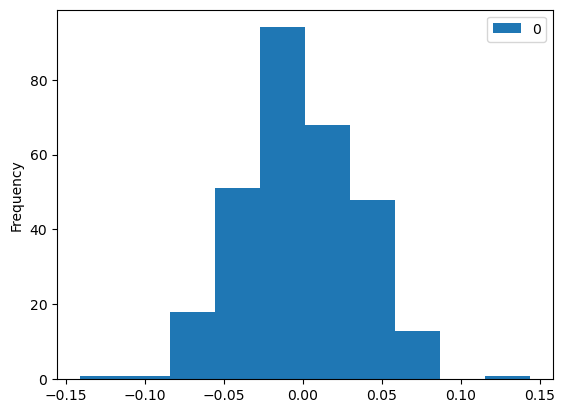

In [25]:
# density plots
print (residuals.plot(kind='hist'))

Axes(0.125,0.11;0.775x0.77)


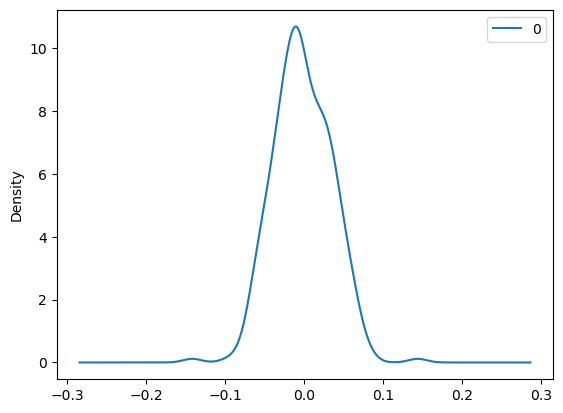

In [26]:
print (residuals.plot(kind='kde'))

We can see that the distribution of residuals is a Normal/Gaussian distribution, because:
- The graphs suggest a Gaussian-like distribution, it has a bell curve
- mean ~ 0 (also median and mode) 
- almost symetric
- Even though the p-value surpassed the defined limit we used it is still considered a Gaussian distribution and a stationary time series with a 94.9% confidence.

### 6 - Model validation

In [27]:
# Validate the arima model with the validate dataset vs the ARIMA prediction
def validate_arima_model(train_test, validate, arima_order):

    train_test = train_test.astype('float32')
    validate = validate.astype('float32')

    # walk-forward validation
    history = [x for x in train_test]
    predictions = []
    for i in range(len(validate)):
      # predict
      model = ARIMA(history, order=arima_order) 
      model_fit = model.fit() #disp=0
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      # observation
      obs = validate[i]
      history.append(obs)

    # report performance
    rmse = sqrt(mean_squared_error(validate, predictions))
    return rmse, validate, predictions

In [28]:
#fit ARIMA model on training set and best_cfg
rmse, validation_dup, predictions = validate_arima_model(dataset, validation, best_cfg)
print('VALIDATE ARIMA%s RMSE=%.3f' % (best_cfg,rmse))

#evaluate predictions using MSE, MAE, and RMSE
mse = mean_squared_error(validation, predictions)
mae = mean_absolute_error(validation, predictions)
rmse = np.sqrt(mse)

print('MSE: %.3f' % mse)
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

VALIDATE ARIMA(4, 0, 4) RMSE=0.032
MSE: 0.001
MAE: 0.026
RMSE: 0.032


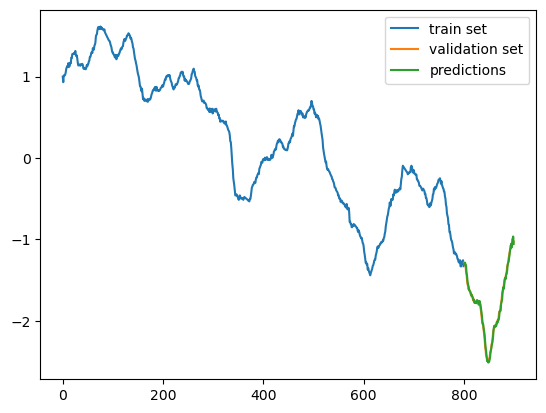

In [29]:
# Plot 'train set','validation set','predictions'

t = np.array([x for x in validation])
t = t.flatten()

pyplot.plot([x for x in dataset]) #first 800 mov
pyplot.plot([None for i in dataset] + [x for x in t]) #100 mov. true (validation)
pyplot.plot([None for i in dataset] + [x for x in predictions]) #100 mov. predictions
pyplot.legend(['train set','validation set','predictions'])
pyplot.show()

# See the diferences between validation and predictions
diff = validation-predictions
# set display option to show all rows
pd.set_option('display.max_rows', None)

# reset display option to default
pd.reset_option('display.max_rows')

We can see that the **results for the validation dataset were good**, because:
- the RMSE for validation dataset (RMSE=0.032) was even better than the RMSE for TrainTest dataset (RMSE=0.036).
- The prediction and the validation set plots are almost 100% aligned.
